## Issues from EDA

### Missing Values
- fill fraud_flag NA with 0 for 26-27th data
- remove gender feature (doesn't have correlation with target variable, even distribution)
- drop rows with missing device/version (9 total) OR fill with mode

### Managing Outliers
- amount
    - drop values > 35650 (based on IQR)
- OR use robust scaler to handle outliers+skew

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


data = pd.read_csv('/Users/scott/Paidy/fraud_exercise/data/data_scientist_fraud_20241009.csv')
# # Copy data to preserve the original
# df = data.copy()

# Step 0: Split data into old and unseen data
data['adjusted_pmt_created_at'] = pd.to_datetime(data['adjusted_pmt_created_at'])
df = data.loc[data['adjusted_pmt_created_at'].dt.day.isin([26, 27])] # old data
df1 = data.loc[~data['adjusted_pmt_created_at'].dt.day.isin([26, 27])] # unseen data

# Step 1: Handle missing values
# Fill categorical columns with mode
df['device'].fillna(df['device'].mode()[0], inplace=True)
df['version'].fillna(df['version'].mode()[0], inplace=True)

# Fill target column missing values with 0
df['fraud_flag'].fillna(0, inplace=True)

# drop consumer_gender feature (doesn't have correlation with target variable, even distribution)
df.drop(columns=['consumer_gender'], inplace=True)

# Step 2: Feature engineering for timestamps
# Convert timestamp columns to datetime format
df['adjusted_acc_created_at'] = pd.to_datetime(df['adjusted_acc_created_at'])

# Extract features from 'adjusted_pmt_created_at'
df['payment_hour'] = df['adjusted_pmt_created_at'].dt.hour
df['payment_day'] = df['adjusted_pmt_created_at'].dt.day
df['payment_weekday'] = df['adjusted_pmt_created_at'].dt.weekday

# Extract features from 'adjusted_acc_created_at'
df['account_hour'] = df['adjusted_acc_created_at'].dt.hour
df['account_day'] = df['adjusted_acc_created_at'].dt.day
df['account_weekday'] = df['adjusted_acc_created_at'].dt.weekday

# Create feature for time between account creation and payment
df['time_diff'] = (df['adjusted_pmt_created_at'] - df['adjusted_acc_created_at']).dt.total_seconds()

# Create additional binary features
df['same_email'] = (df['hashed_buyer_email'] == df['hashed_consumer_email']).astype(int)
df['same_phone'] = (df['hashed_buyer_phone'] == df['hashed_consumer_phone']).astype(int)
df['merchant_first_time'] = (df['merchant_account_age'] == 0).astype(int)

# Step 3: Encode categorical variables
categorical_columns = ['device', 'merchant_name']

encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns),
                          index=df.index)

# Concatenate the one-hot encoded dataframe with the original dataframe
df = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df = df.drop(categorical_columns, axis=1)

# Step 4: Drop high-cardinality and irrelevant columns
columns_to_drop = [
    'payment_id', 'hashed_ip', 'hashed_consumer_id', 'hashed_buyer_email',
    'hashed_consumer_email', 'hashed_buyer_phone', 'hashed_consumer_phone',
    'hashed_zip', 'adjusted_pmt_created_at', 'adjusted_acc_created_at'
]
df.drop(columns=columns_to_drop, inplace=True)

# Step 5: Separate features and target variable for model training
X = df.drop(columns=['fraud_flag'])
y = df['fraud_flag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train.head(), X_test.head(), y_train.head(), y_test.head()

# Conduct feature importance using Random Forest Classifier first to see if scaling is needed

C:\Users\scott\AppData\Local\Temp\ipykernel_27668\360747736.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'].fillna(df['device'].mode()[0], inplace=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_27668\360747736.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['version'].fillna(df['version'].mode()[0], inplace=True)
C:\Users\scott\AppData\Local\Temp\ipykernel_27668\360747736.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

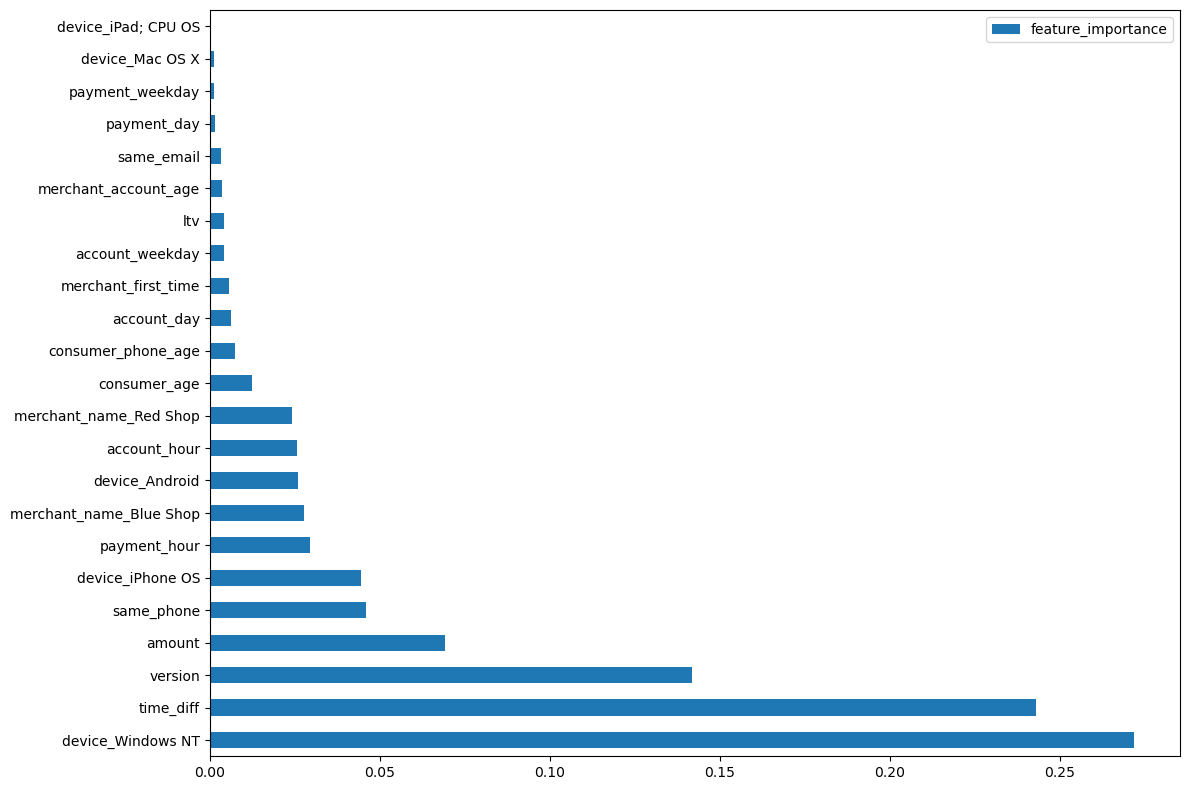

In [2]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# random forest classifier to determine feature importance
feature_names = X_train.columns
forest = RandomForestClassifier(random_state=123)
forest.fit(X_train, y_train)

# visualize feature importances
importances = forest.feature_importances_
forest_importances = pd.DataFrame(importances, index=feature_names, 
                                  columns=['feature_importance']
                                 ).sort_values('feature_importance', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.barh(ax=ax)

fig.tight_layout()

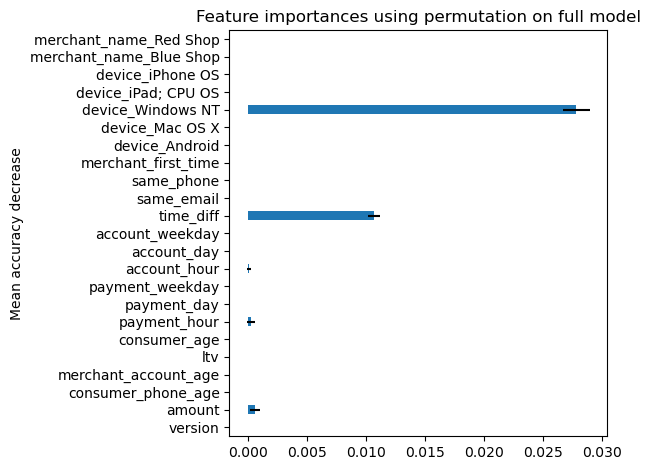

In [3]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [6]:
# Feature importance using mean decrease in impurity (MDI) method
## features were version, device_Windows NT, and time_diff
## version by itself would not make sense as a feature (Windows ver 10 vs iOS ver 10 have no relationship with each other)

# feature importance using using permutation method. will include "amount" since was 4th in MDI
feats = ['device_Windows NT', 'time_diff', 'amount']

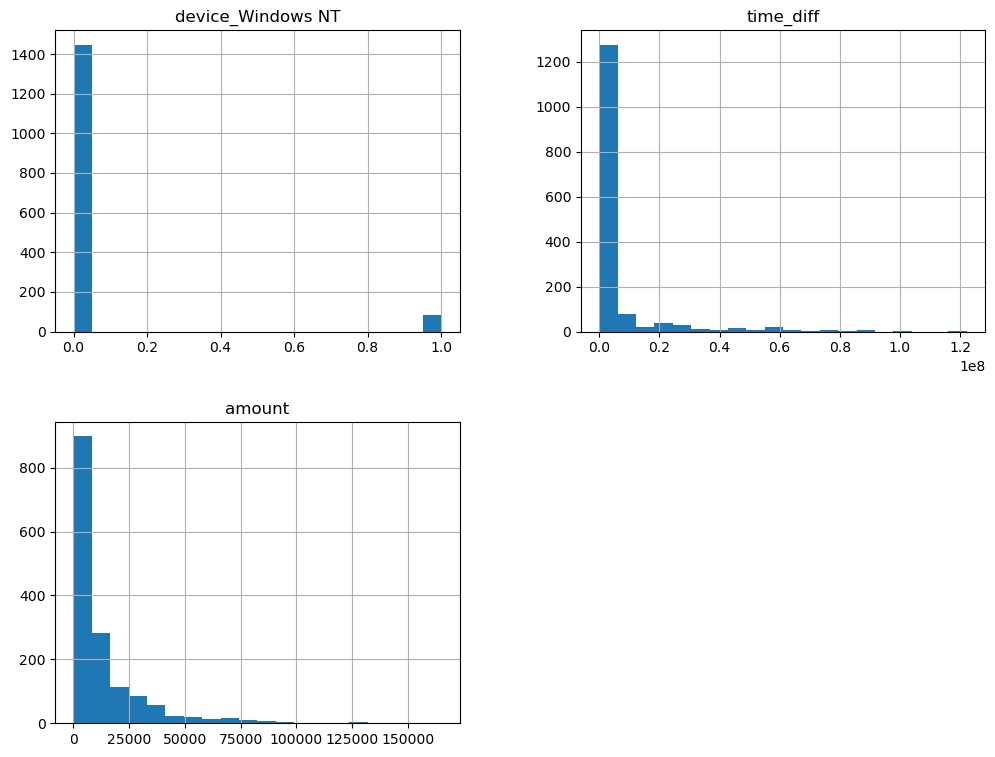

In [7]:
X_train[feats].hist(figsize=(12,9), bins=20);

In [8]:
# time diff and amount will need to be transformed to account for heavy right skew
from sklearn.preprocessing import QuantileTransformer

# Step 6: Scale numerical features
# scaler = RobustScaler() # removes median, scaled to IQR. less sentitive to outliers and skew OR
qt = QuantileTransformer(output_distribution='normal', random_state=0) # for heavy right skew data
numerical_features = [
    'amount', 'time_diff', 
    ]
# scale numerical features using QuantileTransformer
X_train[numerical_features] = qt.fit_transform(X_train[numerical_features])
X_test[numerical_features] = qt.transform(X_test[numerical_features])

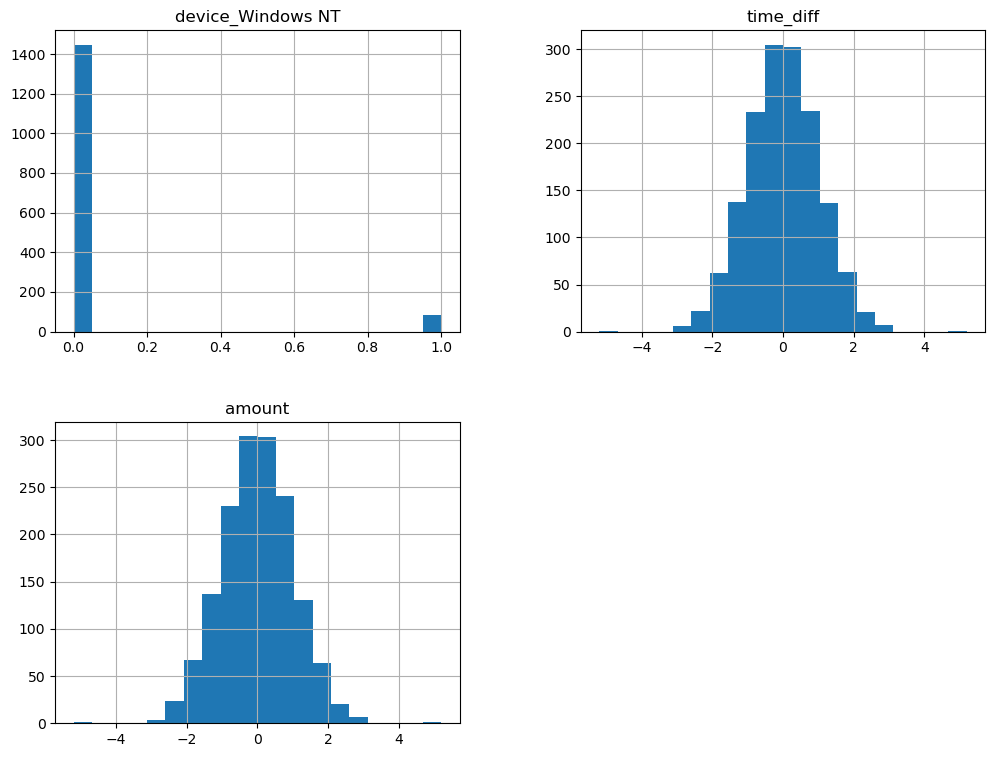

In [9]:
X_train[feats].hist(figsize=(12,9), bins=20);

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from cf_matrix import make_confusion_matrix as cm

import seaborn as sns
sns.set_style('darkgrid')

def build_model(model, model_name, X_train, y_train, X_val, y_val):
    '''
    Input - model: choice of statistical model
            X: features
            y: target
            random_state: default = 123, used for reproducibility
            decision_function: set to false for models with no decision_function method
            
    Output - printed acc, prec, rec, f1, auc scores
             model_dict: dictionary containing model results
    '''

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    try:
        y_score = model.decision_function(X_val)
    except:
        y_score = model.predict_proba(X_val)[:, 1]
        
    fpr, tpr, thresh = roc_curve(y_val, y_score)
    
    acc = accuracy_score(y_val, y_pred)
    pre = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_ = auc(fpr,tpr)
    params = model.get_params()
    cfm = confusion_matrix(y_val, y_pred)
    
    model_dict = {}
    model_dict['model'] = model
    model_dict['y_pred'] = y_pred
    model_dict['y_score'] = y_score
    model_dict['fpr'] = fpr
    model_dict['tpr'] = tpr
    model_dict['thresh'] = thresh
    model_dict['accuracy'] = acc
    model_dict['precision'] = pre
    model_dict['recall'] = rec
    model_dict['f1'] = f1
    model_dict['auc'] = auc_
    model_dict['params'] = params
    model_dict['cfm'] = cfm
    
    print(f'Model: {model_name}')
    print(f'Accuracy: {round(acc, 3)}')
    print(f'Precision: {round(pre, 3)}')
    print(f'Recall: {round(rec, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f'AUC: {round(auc_, 3)}')
    
    return model_dict

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.ensemble import BalancedBaggingClassifier


# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)
bal_classifier = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
# classifier.fit(X_train[feats], y_train)
# preds = classifier.predict(X_test)
# Train models and evaluate with cross-validation
models = {
    "Logistic Regression": log_reg,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting, 
    "Balanced Bagging": bal_classifier
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Perform cross-validation and calculate metrics
    cv_accuracy = cross_val_score(model, X_train[feats], y_train, cv=5, scoring='accuracy').mean()
    cv_precision = cross_val_score(model, X_train[feats], y_train, cv=5, scoring='precision').mean()
    cv_recall = cross_val_score(model, X_train[feats], y_train, cv=5, scoring='recall').mean()
    cv_f1 = cross_val_score(model, X_train[feats], y_train, cv=5, scoring='f1').mean()
    
    # Store results
    results[model_name] = {
        'Accuracy': cv_accuracy,
        'Precision': cv_precision,
        'Recall': cv_recall,
        'F1 Score': cv_f1
    }

results


{'Logistic Regression': {'Accuracy': 0.9947797577228503,
  'Precision': 0.8984848484848484,
  'Recall': 0.9636363636363636,
  'F1 Score': 0.9296442687747037},
 'Random Forest': {'Accuracy': 0.9967384130633796,
  'Precision': 0.9651515151515151,
  'Recall': 0.9454545454545455,
  'F1 Score': 0.9531225296442688},
 'Gradient Boosting': {'Accuracy': 0.9960848182921378,
  'Precision': 0.9303030303030303,
  'Recall': 0.9636363636363636,
  'F1 Score': 0.9462450592885375},
 'Balanced Bagging': {'Accuracy': 0.995431223520896,
  'Precision': 0.9284848484848485,
  'Recall': 0.9454545454545455,
  'F1 Score': 0.935855448898927}}

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_log = Pipeline([('transformer', QuantileTransformer(output_distribution='normal', random_state=0)),
                     ('classifier', LogisticRegression(random_state=42))])

# rf does not need scaling
pipe_rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)

pipe_knn = Pipeline([('transformer', QuantileTransformer(output_distribution='normal', random_state=0)),
                     ('classifier', KNeighborsClassifier())])

pipe_tree = DecisionTreeClassifier(random_state=42)

pipelines = [pipe_log, pipe_rf, pipe_knn, pipe_tree]
pipeline_names = ['LogisticRegression', 'RandomForest', 'KNeighbors', 'DecisionTree']

In [13]:
models = {}
for name, pipeline in zip(pipeline_names, pipelines):
    print(f'Running {name} process, saving to dictionary')
    models[name] = build_model(pipeline, name, X_train[feats], y_train, X_test[feats], y_test)

Running LogisticRegression process, saving to dictionary
Model: LogisticRegression
Accuracy: 0.995
Precision: 0.867
Recall: 0.929
F1 Score: 0.897
AUC: 0.999
Running RandomForest process, saving to dictionary
Model: RandomForest
Accuracy: 0.997
Precision: 0.875
Recall: 1.0
F1 Score: 0.933
AUC: 0.999
Running KNeighbors process, saving to dictionary
Model: KNeighbors
Accuracy: 0.997
Precision: 0.875
Recall: 1.0
F1 Score: 0.933
AUC: 0.998
Running DecisionTree process, saving to dictionary
Model: DecisionTree
Accuracy: 0.994
Precision: 0.857
Recall: 0.857
F1 Score: 0.857
AUC: 0.927


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [14]:
results = pd.DataFrame(models).T
results = results[['model', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'params', 'cfm']]
results

,model,accuracy,precision,recall,f1,auc,params,cfm
LogisticRegression,(QuantileTransformer(output_distribution='norm...,0.995441,0.866667,0.928571,0.896552,0.998558,"{'memory': None, 'steps': [('transformer', Qua...","[[642, 2], [1, 13]]"
RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.99696,0.875,1.0,0.933333,0.999335,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","[[642, 2], [0, 14]]"
KNeighbors,(QuantileTransformer(output_distribution='norm...,0.99696,0.875,1.0,0.933333,0.998114,"{'memory': None, 'steps': [('transformer', Qua...","[[642, 2], [0, 14]]"
DecisionTree,DecisionTreeClassifier(random_state=42),0.993921,0.857143,0.857143,0.857143,0.927019,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...","[[642, 2], [2, 12]]"


In [15]:
def plot_matrix(cfm, title):
    '''
    Input - cfm: confusion matrix
    
    Output - matrix: custom confusion matrix visualization
    '''
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Not Flagged', 'Flagged']
    matrix = cm(cfm, group_names=labels, figsize=(10,6),
               categories=categories, cbar=False, cmap='Purples', title=title)
    
    return matrix

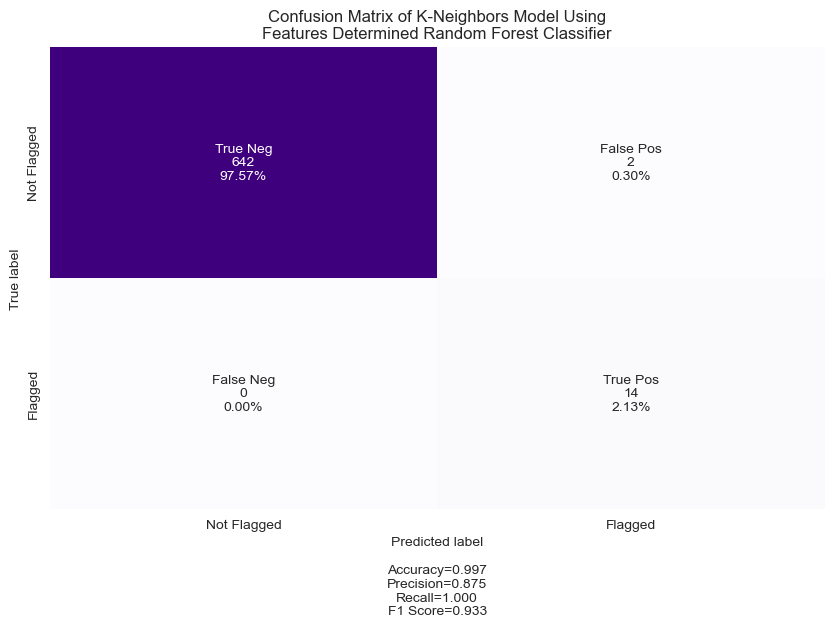

In [16]:
title = 'Confusion Matrix of K-Neighbors Model Using\nFeatures Determined Random Forest Classifier'
fig = plot_matrix(models['KNeighbors']['cfm'], title)
# print(f'Confusion Matrix of Logistic Regression Model Using\nFeatures Determined by MDI')
fig

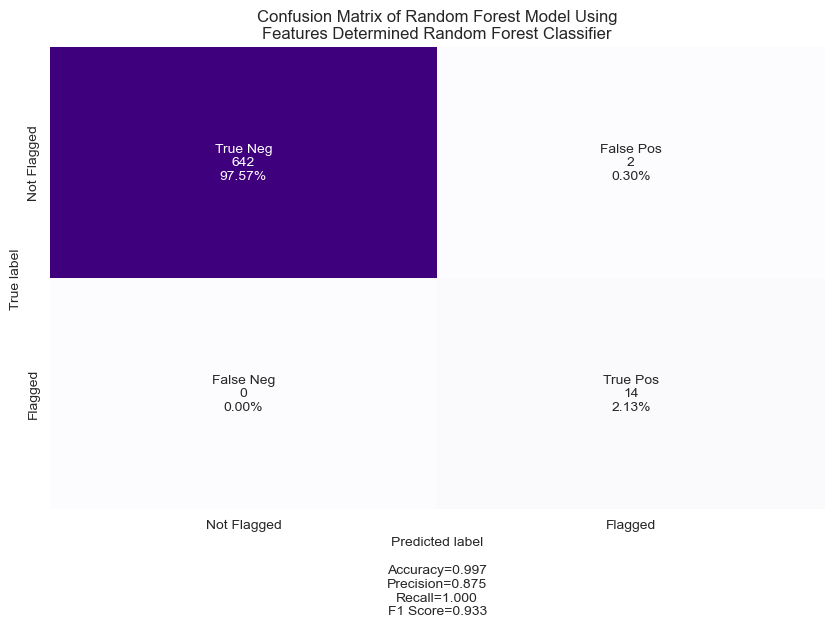

In [17]:
title = 'Confusion Matrix of Random Forest Model Using\nFeatures Determined Random Forest Classifier'
fig = plot_matrix(models['RandomForest']['cfm'], title)
# print(f'Confusion Matrix of Logistic Regression Model Using\nFeatures Determined by MDI')
fig

The "Best" performing model out of the 4 trained on the dataset using the best features as determined by a random forest classifier feature importance was the __random forest classifier__ and __K neighbors__ models. This decision was based off of their high f1 and AUC values.

However, both of these measure are highly deceiving for one major reason, that being the high class imbalance between the negative and positive cases in the target variable "fraud_flag".
In the training data, there is a 96:4 ratio between cases of non-fraud and fraud, respectively.
In practice, that means that even if the model were to guess that every single transaction was NOT fraud, it would still perform very well with an accuracy score, and most likely f1 and AUC scores, of around 96%.


## Major Shortcomings / Future Improvements

1. The heavy imbalanced nature of the dataset caused model performance to look "good" based off of general accuracy and AUC metrics. However, this was only due to the underlying bias towards a certain outcome.
    - To solve imbalance, SMOTE (oversampling of the minority class) techniques or random undersampling of the majority class can be used before training the models
        - Undersampling in this case is NOT recommended as this would greatly decrease the number of available data points
2. Additional feature engineering steps using domain knowledge. With additional readings of current research in the fraud analysis domain, certain underlying features could have been engineered to better predict the defaulting outcome of a consumer.
3. Additional models like XGBoost and SVM could have been tested and tuned for better performance. 
4. Additional fine tuning using KFold-CV methods can be used to test multiple subsets of the dataset.
5. Once the above improvements are implemented, a grid search of the selected model can be performed to hypertune certain parameters to further improve model performance.
    - Hypertuning using a gridsearch method is recommended. But results will only display the "best" model from the parameters the user has selected which can be very restrictive. More paramters can be selected to test during the process, but this has a large computational and time cost.

## Creating full data set

In [18]:
df1['adjusted_acc_created_at'] = pd.to_datetime(df1['adjusted_acc_created_at'])
df1['time_diff'] = (df1['adjusted_pmt_created_at'] - df1['adjusted_acc_created_at']).dt.total_seconds()

# Step 3: Encode categorical variables
categorical_columns = ['device', 'merchant_name']

encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical columns
one_hot_encoded = encoder.fit_transform(df1[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns),
                          index=df1.index)

# Concatenate the one-hot encoded dataframe with the original dataframe
df1 = pd.concat([df1, one_hot_df], axis=1)

C:\Users\scott\AppData\Local\Temp\ipykernel_27668\2959529181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['adjusted_acc_created_at'] = pd.to_datetime(df1['adjusted_acc_created_at'])
C:\Users\scott\AppData\Local\Temp\ipykernel_27668\2959529181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time_diff'] = (df1['adjusted_pmt_created_at'] - df1['adjusted_acc_created_at']).dt.total_seconds()


In [29]:
d1 = df1.reset_index(drop=True)
d1

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,...,consumer_age,time_diff,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,device_nan,merchant_name_Blue Shop,merchant_name_Red Shop
0,NaN,1,ip_1,iPhone OS,13.0,2021-04-28 13:40:40.642,Red Shop,consumer_1170,2021-03-26 11:52:01.881,4370,...,39,2.857719e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,NaN,2,ip_2,iPhone OS,13.0,2021-04-30 19:11:16.507,Red Shop,consumer_6145,2021-04-30 19:10:21.403,1350,...,29,5.510400e+01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,NaN,3,ip_2,iPhone OS,13.0,2021-04-30 19:10:06.264,Red Shop,consumer_6145,2021-04-30 19:10:21.403,1350,...,42,-1.513900e+01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,NaN,4,ip_3,Android,8.0,2021-04-30 09:04:22.531,Blue Shop,consumer_5619,2021-04-30 09:04:40.176,7250,...,52,-1.764500e+01,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,NaN,5,ip_4,iPhone OS,13.0,2021-05-05 15:26:28.023,Red Shop,consumer_1318,2021-04-10 12:29:29.287,16492,...,26,2.170619e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11043,NaN,13233,ip_8143,iPhone OS,12.0,2021-04-28 10:57:05.323,Red Shop,consumer_2127,2021-04-26 22:20:19.547,1700,...,61,1.318058e+05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
11044,NaN,13235,ip_8143,iPhone OS,12.0,2021-05-07 20:35:33.339,Red Shop,consumer_2127,2021-04-26 22:20:19.547,680,...,26,9.441138e+05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
11045,NaN,13237,ip_8143,iPhone OS,12.0,2021-05-01 20:33:13.899,Red Shop,consumer_2127,2021-04-26 22:20:19.547,890,...,20,4.255744e+05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
11046,NaN,13238,ip_8143,iPhone OS,12.0,2021-05-01 20:34:10.884,Red Shop,consumer_2127,2021-04-26 22:20:19.547,890,...,38,4.256313e+05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [37]:
model = models['RandomForest']['model']
res = model.predict(df1[feats])
res = pd.Series(res, index=df1.index)
res = pd.concat([df1, res], axis=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [40]:
res.drop('fraud_flag', inplace=True, axis=1)
res.rename(columns={0:'fraud_flag'}, inplace=True)

In [43]:
res['fraud_flag']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13232    0.0
13234    0.0
13236    0.0
13237    0.0
13238    0.0
Name: fraud_flag, Length: 11048, dtype: float64

In [44]:
df['fraud_flag']

9        0.0
12       0.0
13       0.0
16       0.0
77       0.0
        ... 
13226    0.0
13227    0.0
13231    0.0
13233    0.0
13235    0.0
Name: fraud_flag, Length: 2191, dtype: float64

In [47]:
frauds = pd.concat([df['fraud_flag'], res['fraud_flag']])
frauds

9        0.0
12       0.0
13       0.0
16       0.0
77       0.0
        ... 
13232    0.0
13234    0.0
13236    0.0
13237    0.0
13238    0.0
Name: fraud_flag, Length: 13239, dtype: float64

In [49]:
final = data.drop('fraud_flag', axis=1)
final = pd.concat([final, frauds], axis=1)
final

,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age,fraud_flag
0,1,ip_1,iPhone OS,13.0,2021-04-28 13:40:40.642,Red Shop,consumer_1170,2021-03-26 11:52:01.881000,4370,email_0000002076@docomo.ne.jp,email_0000002076@docomo.ne.jp,818000003108,818000003108,106,345,3480,1204011,Male,39,0.0
1,2,ip_2,iPhone OS,13.0,2021-04-30 19:11:16.507,Red Shop,consumer_6145,2021-04-30 19:10:21.403000,1350,email_000000005732@icloud.com,email_000000005732@icloud.com,818000002287,818000002287,110,0,0,1155022,Female,29,0.0
2,3,ip_2,iPhone OS,13.0,2021-04-30 19:10:06.264,Red Shop,consumer_6145,2021-04-30 19:10:21.403000,1350,email_000000005732@icloud.com,email_000000005732@icloud.com,818000002287,818000002287,1,0,0,1155022,Male,42,0.0
3,4,ip_3,Android,8.0,2021-04-30 09:04:22.531,Blue Shop,consumer_5619,2021-04-30 09:04:40.176000,7250,email_0000000000000001070@yahoo.co.jp,email_0000000000000001070@yahoo.co.jp,819000005271,819000005271,200,0,0,5848915,Female,52,0.0
4,5,ip_4,iPhone OS,13.0,2021-05-05 15:26:28.023,Red Shop,consumer_1318,2021-04-10 12:29:29.287000,16492,email_006289@i.softbank.jp,email_006289@i.softbank.jp,818000002516,818000002516,144,567,20000,1155816,Female,26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13234,13235,ip_8143,iPhone OS,12.0,2021-05-07 20:35:33.339,Red Shop,consumer_2127,2021-04-26 22:20:19.547000,680,email_000001625@softbank.ne.jp,email_000001625@softbank.ne.jp,818000001983,818000001983,84,55,890,5938893,NaN,26,0.0
13235,13236,ip_8143,iPhone OS,12.0,2021-04-26 22:20:07.475,Red Shop,consumer_2127,2021-04-26 22:20:19.547000,400,email_000001625@softbank.ne.jp,email_000001625@softbank.ne.jp,818000001983,818000001983,21,44,1400,5938893,Female,23,0.0
13236,13237,ip_8143,iPhone OS,12.0,2021-05-01 20:33:13.899,Red Shop,consumer_2127,2021-04-26 22:20:19.547000,890,email_000001625@softbank.ne.jp,email_000001625@softbank.ne.jp,818000001983,818000001983,140,49,3100,5938893,Female,20,0.0
13237,13238,ip_8143,iPhone OS,12.0,2021-05-01 20:34:10.884,Red Shop,consumer_2127,2021-04-26 22:20:19.547000,890,email_000001625@softbank.ne.jp,email_000001625@softbank.ne.jp,818000001983,818000001983,140,49,3100,5938893,NaN,38,0.0


In [53]:
final.loc[final['fraud_flag']==1, ['device']]

,device
59,Windows NT
1174,Windows NT
1224,Windows NT
1316,Windows NT
1323,Windows NT
...,...
12698,Windows NT
12765,Windows NT
12816,Windows NT
13029,Windows NT


In [54]:
final.to_csv('../data/final_fraud_labeled_dataset.csv', index=False)

# to do
- create full data set with all features + potentially fraudulent payments flagged from 4/28~
    - remove reset_index flag, rerun notebook, combine on index (with _data_ variable)
    - check amount flag to check if value is same after concat
- based on chosen 3 feautres, how would you monitor proposed solution?
    - is windows phone
    - is payment created prior to account
    - amount
        - create visual comparing amounts and fraud from old df
- create some visuals / choose visuals to include
- create presentation

### How to Monitor Proposed Solution Based on Model Features


In [55]:
feats

['device_Windows NT', 'time_diff', 'amount']

In [59]:
final.loc[final['device']=='Windows NT', 'fraud_flag'].value_counts(normalize=True)

fraud_flag
1.0    0.778512
0.0    0.221488
Name: proportion, dtype: float64

- based on the features with the 2 strongest importance, I would set up a monitor that would alert the operators for any customer that uses a Windows phone and where the payment timestamp was created prior to the Paidy account being created

In [63]:
# final rows where fraud_flag==1 and ltv>0
final.loc[(final['fraud_flag']==1) & (final['ltv']>0)]

,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age,fraud_flag
1848,1849,ip_1198,Windows NT,10.0,2021-05-03 13:02:54.731,Red Shop,consumer_4061,2021-05-03 13:03:08.111000,7315,email_00000003828@gmail.com,email_00000003828@gmail.com,818000001419,818000001419,161,359,1790,3508097,Male,53,1.0
2539,2540,ip_1638,Windows NT,10.0,2021-04-29 23:17:40.523,Red Shop,consumer_5430,2021-04-29 23:17:55.848000,18810,email_00000002532@cream.plala.or.jp,email_00000002532@cream.plala.or.jp,818000001917,818000001917,182,401,1150,4408094,NaN,41,1.0
3761,3762,ip_2365,Windows NT,6.0,2021-05-04 13:24:06.946,Red Shop,consumer_4848,2021-05-04 13:25:29.001000,650,email_000006248@outlook.jp,email_000006248@outlook.jp,818000003154,818000003154,7,276,800,5548134,Female,68,1.0
3891,3892,ip_2459,Windows NT,10.0,2021-05-01 22:17:49.801,Red Shop,consumer_7099,2021-05-01 22:18:05.959000,80000,email_000000000000000001320@yahoo.co.jp,email_00005369@ezweb.ne.jp,817000000262,819000006110,1,691,1500,4138114,NaN,44,1.0
3893,3894,ip_2459,Windows NT,10.0,2021-05-01 21:59:07.999,Red Shop,consumer_6880,2021-05-01 21:59:23.591000,80000,email_000000000000000001320@yahoo.co.jp,email_000000000000000001320@yahoo.co.jp,817000000262,817000000262,175,691,1500,4138114,Male,39,1.0
4005,4006,ip_2540,Windows NT,10.0,2021-05-06 12:56:47.020,Red Shop,consumer_6830,2021-05-06 12:57:30.038000,3040,email_00001464@ybb.ne.jp,email_00001464@ybb.ne.jp,819000006207,819000006207,6,645,2500,3428645,Female,19,1.0
7602,7603,ip_4820,Windows NT,10.0,2021-04-29 21:27:46.015,Red Shop,consumer_5432,2021-04-29 21:28:06.801000,22990,email_0000000002934@yahoo.co.jp,email_0000000002934@yahoo.co.jp,819000006163,819000006163,10,304,2000,9518133,Female,36,1.0
7829,7830,ip_4969,Windows NT,10.0,2021-05-07 20:06:33.954,Red Shop,consumer_2635,2021-05-07 20:07:05.846000,2200,email_0000000004502@bird.ocn.ne.jp,email_0000000004502@bird.ocn.ne.jp,814800000137,819000005179,21,38,7500,6178119,NaN,18,1.0


In [64]:
final['device'].value_counts()

device
iPhone OS       9584
Android         2846
Windows NT       605
Mac OS X          83
iPad; CPU OS      34
Name: count, dtype: int64

KeyError: 'device'